In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from scipy.linalg import svd
from collections import defaultdict
from scipy.stats import mode, itemfreq
from scipy import delete
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC as SVM
import operator
from biom import load_table
from random import randint
import seaborn as sns
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, MatrixFactorization
import math
from wpca import WPCA, EMPCA
from gneiss.sort import mean_niche_estimator, niche_sort
from gneiss.util import match
from gneiss.balances import balance_basis
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,inner, perturb_inv, clr, clr_inv, centralize)
from skbio import TreeNode, DistanceMatrix
from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
import copy
from r_pca import R_pca #alternate completion than fancy impute
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from base_impute import base
from error_impute import error
from Impute_utils_vis import PCA_niche
from skbio.stats.composition import centralize, clr
from gneiss.regression import ols
from pba import proportional_linkage
%matplotlib inline

Using TensorFlow backend.


In [2]:
def fancy_dendrogram(*args, **kwargs):
    
    '''''
    From https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    '''''
    
    
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('Sample Index or (Cluster Size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### From gneiss https://github.com/biocore/gneiss

In [3]:
def convert_biom_to_pandas(table):

    
    '''''
    From gneiss notebooks https://github.com/biocore/gneiss
    '''''

    
    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

# Import .biom, taxonomy and meta data

In [4]:
#Mapping

mappingdf= pd.read_table('data/soil_map.txt', index_col=0)
label_save=[]
#save names
mappingdf=mappingdf.dropna(subset=['pH'])
mappingdf.sort(['pH'], ascending = [True], inplace = True)

# set sting based netadata to numerical classifiers
classifier_names = mappingdf.columns.values.tolist()
imdex_list = mappingdf.index.values.tolist()
for nm in classifier_names:

    if mappingdf[nm].dtype == np.dtype(object) or mappingdf[nm].dtype == np.dtype(bool) :
        
        # get set of strings in column
        mappingdfList = mappingdf[nm].tolist()
        mappingdflistset = set(mappingdfList)
        mappingdfsetdict={}
        q=0
        # assign each string in set a integer classifier
        for tmpclassify in mappingdflistset:
            mappingdfsetdict[tmpclassify]=q
            q+=1
        label_save.append(mappingdfsetdict)
                    
samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)

#BIOM

table = load_table('data/88_soils.biom')
read_filter = lambda val, id_, md: sum(val) > 1
table.filter(read_filter, axis='sample') 
table.filter(read_filter, axis='observation')
otu, taxonomy = convert_biom_to_pandas(table)
otu=otu.T


otus_index=[]
for q in range(len(otu.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')
otu=otu.T
taxonomy['all'] = taxonomy[['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']].apply(lambda x: ''.join(x), axis=1)
tax_index=list(taxonomy['all'].values)

# fill any unknown with zero and drop any all zero rows (double check all zeros cause singular matrix)
otu=otu.fillna(0)
otu.isnull().values.any()
otu = otu.loc[(otu.sum(axis=1) != 0), (otu.sum(axis=0) != 0)]

#drop any samples in mapping not in biom
index = otu.index.values.tolist()
indexmappingdf = mappingdf.index.values.tolist()
for checkotu in index:
    check=list(filter(lambda x: checkotu == str(x), indexmappingdf))
    if len(check)>=1:
        continue 
    else:
        otu.drop(str(checkotu),0,inplace=True)

    
#drop any samples in mapping not in mappingdf

index = otu.index.values.tolist()
indexmappingdf = mappingdf.index.values.tolist()
for checkotu in indexmappingdf:
    check=list(filter(lambda x: checkotu == x, index))
    if len(check)>=1:
        continue 
    else:
        mappingdf.drop(checkotu,0,inplace=True)
        
# save data and names from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = map(str, ids)

for j in range(len(data[:][:])-1):
    if sum(list(data[j][:])) < 1:
                print(j) 

/Users/cameronmartino/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


# Remove OTU values at the lowest frequency until density reaches desired value

To simulate the "missing" values in an OTU table density will be lowered from the original OTU table by removing the lowest frequency OTUs in reach sample. 

Note: The sum of any OTU row can not be zero or a singular matrix will be formed, preventing SVD and many of the imputation methods. 

### There are a eight different imputation methods used.

#### Fancy Impute: (https://github.com/hammerlab/fancyimpute)

* `SoftImpute`: Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the [softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html) package for R, which is based on [Spectral Regularization Algorithms for Learning Large Incomplete Matrices](http://web.stanford.edu/~hastie/Papers/mazumder10a.pdf) by Mazumder et. al.

* `IterativeSVD`: Matrix completion by iterative low-rank SVD decomposition. Should be similar to SVDimpute from [Missing value estimation methods for DNA microarrays](http://www.ncbi.nlm.nih.gov/pubmed/11395428) by Troyanskaya et. al.

* `MatrixFactorization`: Direct factorization of the incomplete matrix into low-rank `U` and `V`, with an L1 sparsity penalty on the elements of `U` and an L2 penalty on the elements of `V`. Solved by gradient descent.


#### EMPCA and WPCA: (https://github.com/jakevdp/wpca)

- ``WPCA`` uses a direct decomposition of a weighted covariance matrix to
  compute principal vectors, and then a weighted least squares optimization
  to compute principal components. It is based on the algorithm presented
  in [Delchambre (2014)](http://arxiv.org/abs/1412.4533)

- ``EMPCA`` uses an iterative expectation-maximization approach to solve
  simultaneously for the principal vectors and principal components of
  weighted data. It is based on the algorithm presented in
  [Bailey (2012)](http://arxiv.org/abs/1208.4122).

#### Nuclear Norm, Decomposition (https://github.com/dganguli/robust-pca)

* `RPCA`: Nuclear Norm,Convex optimized decomposition http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

##### Base comparison :

* `Zeros`: All unknown values are replaced with zeros. An effective method for 16S analysis due to the fact that most missing entries are low frequency.





In [107]:
############################  makes most sense (min only) #######################

# removes min value that is greater than zero (checks density) in each iteration randomly chosen 

#density range to run
nonzeroscount=np.count_nonzero(data)
sizel = data.shape
totalentr=sizel[0]*sizel[1]
end=0.02 # final density to test 
begin=(nonzeroscount/totalentr) # Begning density of matrix 
step=.01 # step of density


#intialize lists to store
density_in=[]
RMSE_empca_scores=[]
RMSE_wpca_scores=[]
RMSE_sfi_scores=[]
RMSE_siv_scores=[]
RMSE_sni_scores=[]
RMSE_smi_scores=[]
RMSE_szi_scores=[]
Density_empca=[]
Density_wpca=[]
Density_sfi=[]
Density_siv=[]
Density_sni=[]
Density_smi=[]
Density_szi=[]

#radnomly remove values from known matrix and try to impute them 

for d in reversed(np.arange(end,begin,step)):
    otum=data.T.copy()
    
    #begin density check 
    nonzeroscount=np.count_nonzero(otum)
    sizel = otum.shape
    totalentr=sizel[0]*sizel[1]
    
    while np.float64((nonzeroscount/totalentr)) > d:
        #remove a min frequency OTU and then check density
        j=randint(0,len(otum[:][:])-1)
        #make sure row is not all zero (all zero row causes singular matrix)
        if sum(list(otum[j][:])) < 1:
            continue 
        m = min(i for i in list(otum[j][:]) if i > 0)
        #make sure removing value will not result in zero row
        if sum(list(otum[j][:])) == m:
            continue 
        otum[j][list(otum[j][:]).index(m)]=0
        #check denstiy to break  
        nonzeroscount=float(np.count_nonzero(otum))
        sizel = otum.shape
        totalentr=float(sizel[0])*float(sizel[1])
        
        
    # coherce float of the unknown and print new density 
    print("OTU table of %f generated"%d)
    otum=otum.T.astype(np.float64)

    # make zero unknown for fancy impute, avoid singular matrix by taking transpose 
    otum2=otum.T.copy()
    otum2=otum2.astype(np.float64)
    otum2[otum2 == 0] = np.nan #make unknown nan 

    #WPCA and EMPCA 
    
    #build wieghted matrix 
    weight = otum.copy()
    for i in range(len(otum2.T)):
        for j in range(len(otum2.T[i])):
            if otum2.T[i][j]==0:
                weight[i][j]=1
            else:
                weight[i][j]=1000
            
    print("Running EMPCA")
    EMPCAi = EMPCA(n_components=3).fit_reconstruct(otum.copy(),weight)
    print("Running WPCA")
    WPCAi = WPCA(n_components=3).fit_reconstruct(otum.copy(),weight)
    
    #nuclear norm
    print("Running Nuclear Norm Minimization") 
    iteration_used=10000
    rpca=R_pca(otum.T.copy())
    sni,S=rpca.fit(max_iter=iteration_used,iter_print=int(iteration_used))
    sni=(sni+abs(sni.min())) # adjust imputed values be [0,inf]
    
    # fancy impute and zeros
    print("Running Soft Impute")
    sfi=SoftImpute(shrinkage_value=None,convergence_threshold=0.00001,max_iters=1000,max_rank=min(otum2.shape),n_power_iterations=1,init_fill_method="zero",min_value=0,max_value=(np.amax(otum2)),normalizer=None,verbose=False).complete(otum2.copy())
    print("Running Iterative SVD")
    siv=IterativeSVD(rank=(min(otum2.shape)-1),convergence_threshold=0.00001,max_iters=1000,gradual_rank_increase=True,svd_algorithm="arpack",init_fill_method="zero",min_value=0,max_value=(np.amax(otum2)),verbose=False).complete(otum2.copy())
    print("Running Matrix Factorization")
    smi=MatrixFactorization(rank=(min(otum2.shape)-1),initializer=np.random.randn,learning_rate=0.01,patience=5,l1_penalty=0.05,l2_penalty=0.05,min_improvement=0.01,max_gradient_norm=5,optimization_algorithm="adam",min_value=0,max_value=(np.amax(otum2)),verbose=False).complete(otum2.copy())              
    print("Imputing by filling with zeros for base comparison")
    szi=base.zeros(otum2.copy())
 
    # save the results 
    
    #density in (after removed values) 
    density_in.append(error.get_density(otum))
    
    # density imputed 
    Density_empca.append(error.get_density(EMPCAi))
    Density_wpca.append(error.get_density(WPCAi))
    Density_sfi.append(error.get_density(sfi))
    Density_siv.append(error.get_density(siv))
    Density_sni.append(error.get_density(sni))
    Density_smi.append(error.get_density(smi))
    Density_szi.append(error.get_density(szi))
    
    # RMSE of imputed values 
    missing_mask = np.isnan(otum2.T) # masking to only check RMSE between values imputed and values removed 
    RMSE_empca_scores.append(error.RMSE(data,EMPCAi,missing_mask))
    RMSE_wpca_scores.append(error.RMSE(data,WPCAi,missing_mask))
    RMSE_sfi_scores.append(error.RMSE(data,sfi.T,missing_mask))
    RMSE_siv_scores.append(error.RMSE(data,siv.T,missing_mask))
    RMSE_sni_scores.append(error.RMSE(data,sni.T,missing_mask))
    RMSE_smi_scores.append(error.RMSE(data,smi.T,missing_mask))
    RMSE_szi_scores.append(error.RMSE(data,szi.T,missing_mask))

OTU table of 0.060000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 503.1761991781978
iteration: 50, error: 0.04052341993863993
Running Soft Impute
Running Iterative SVD
Running Matrix Factorization
Imputing by filling with zeros for base comparison
OTU table of 0.050000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 449.3543370905953
iteration: 51, error: 0.012584755132562716
Running Soft Impute
Running Iterative SVD
Running Matrix Factorization
Imputing by filling with zeros for base comparison
OTU table of 0.040000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, error: 392.25712180640255
iteration: 50, error: 0.06363578378800293
Running Soft Impute
Running Iterative SVD
Running Matrix Factorization
Imputing by filling with zeros for base comparison
OTU table of 0.030000 generated
Running EMPCA
Running WPCA
Running Nuclear Norm Minimization
iteration: 1, err

/Users/cameronmartino/anaconda/envs/py3k/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/cameronmartino/anaconda/envs/py3k/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


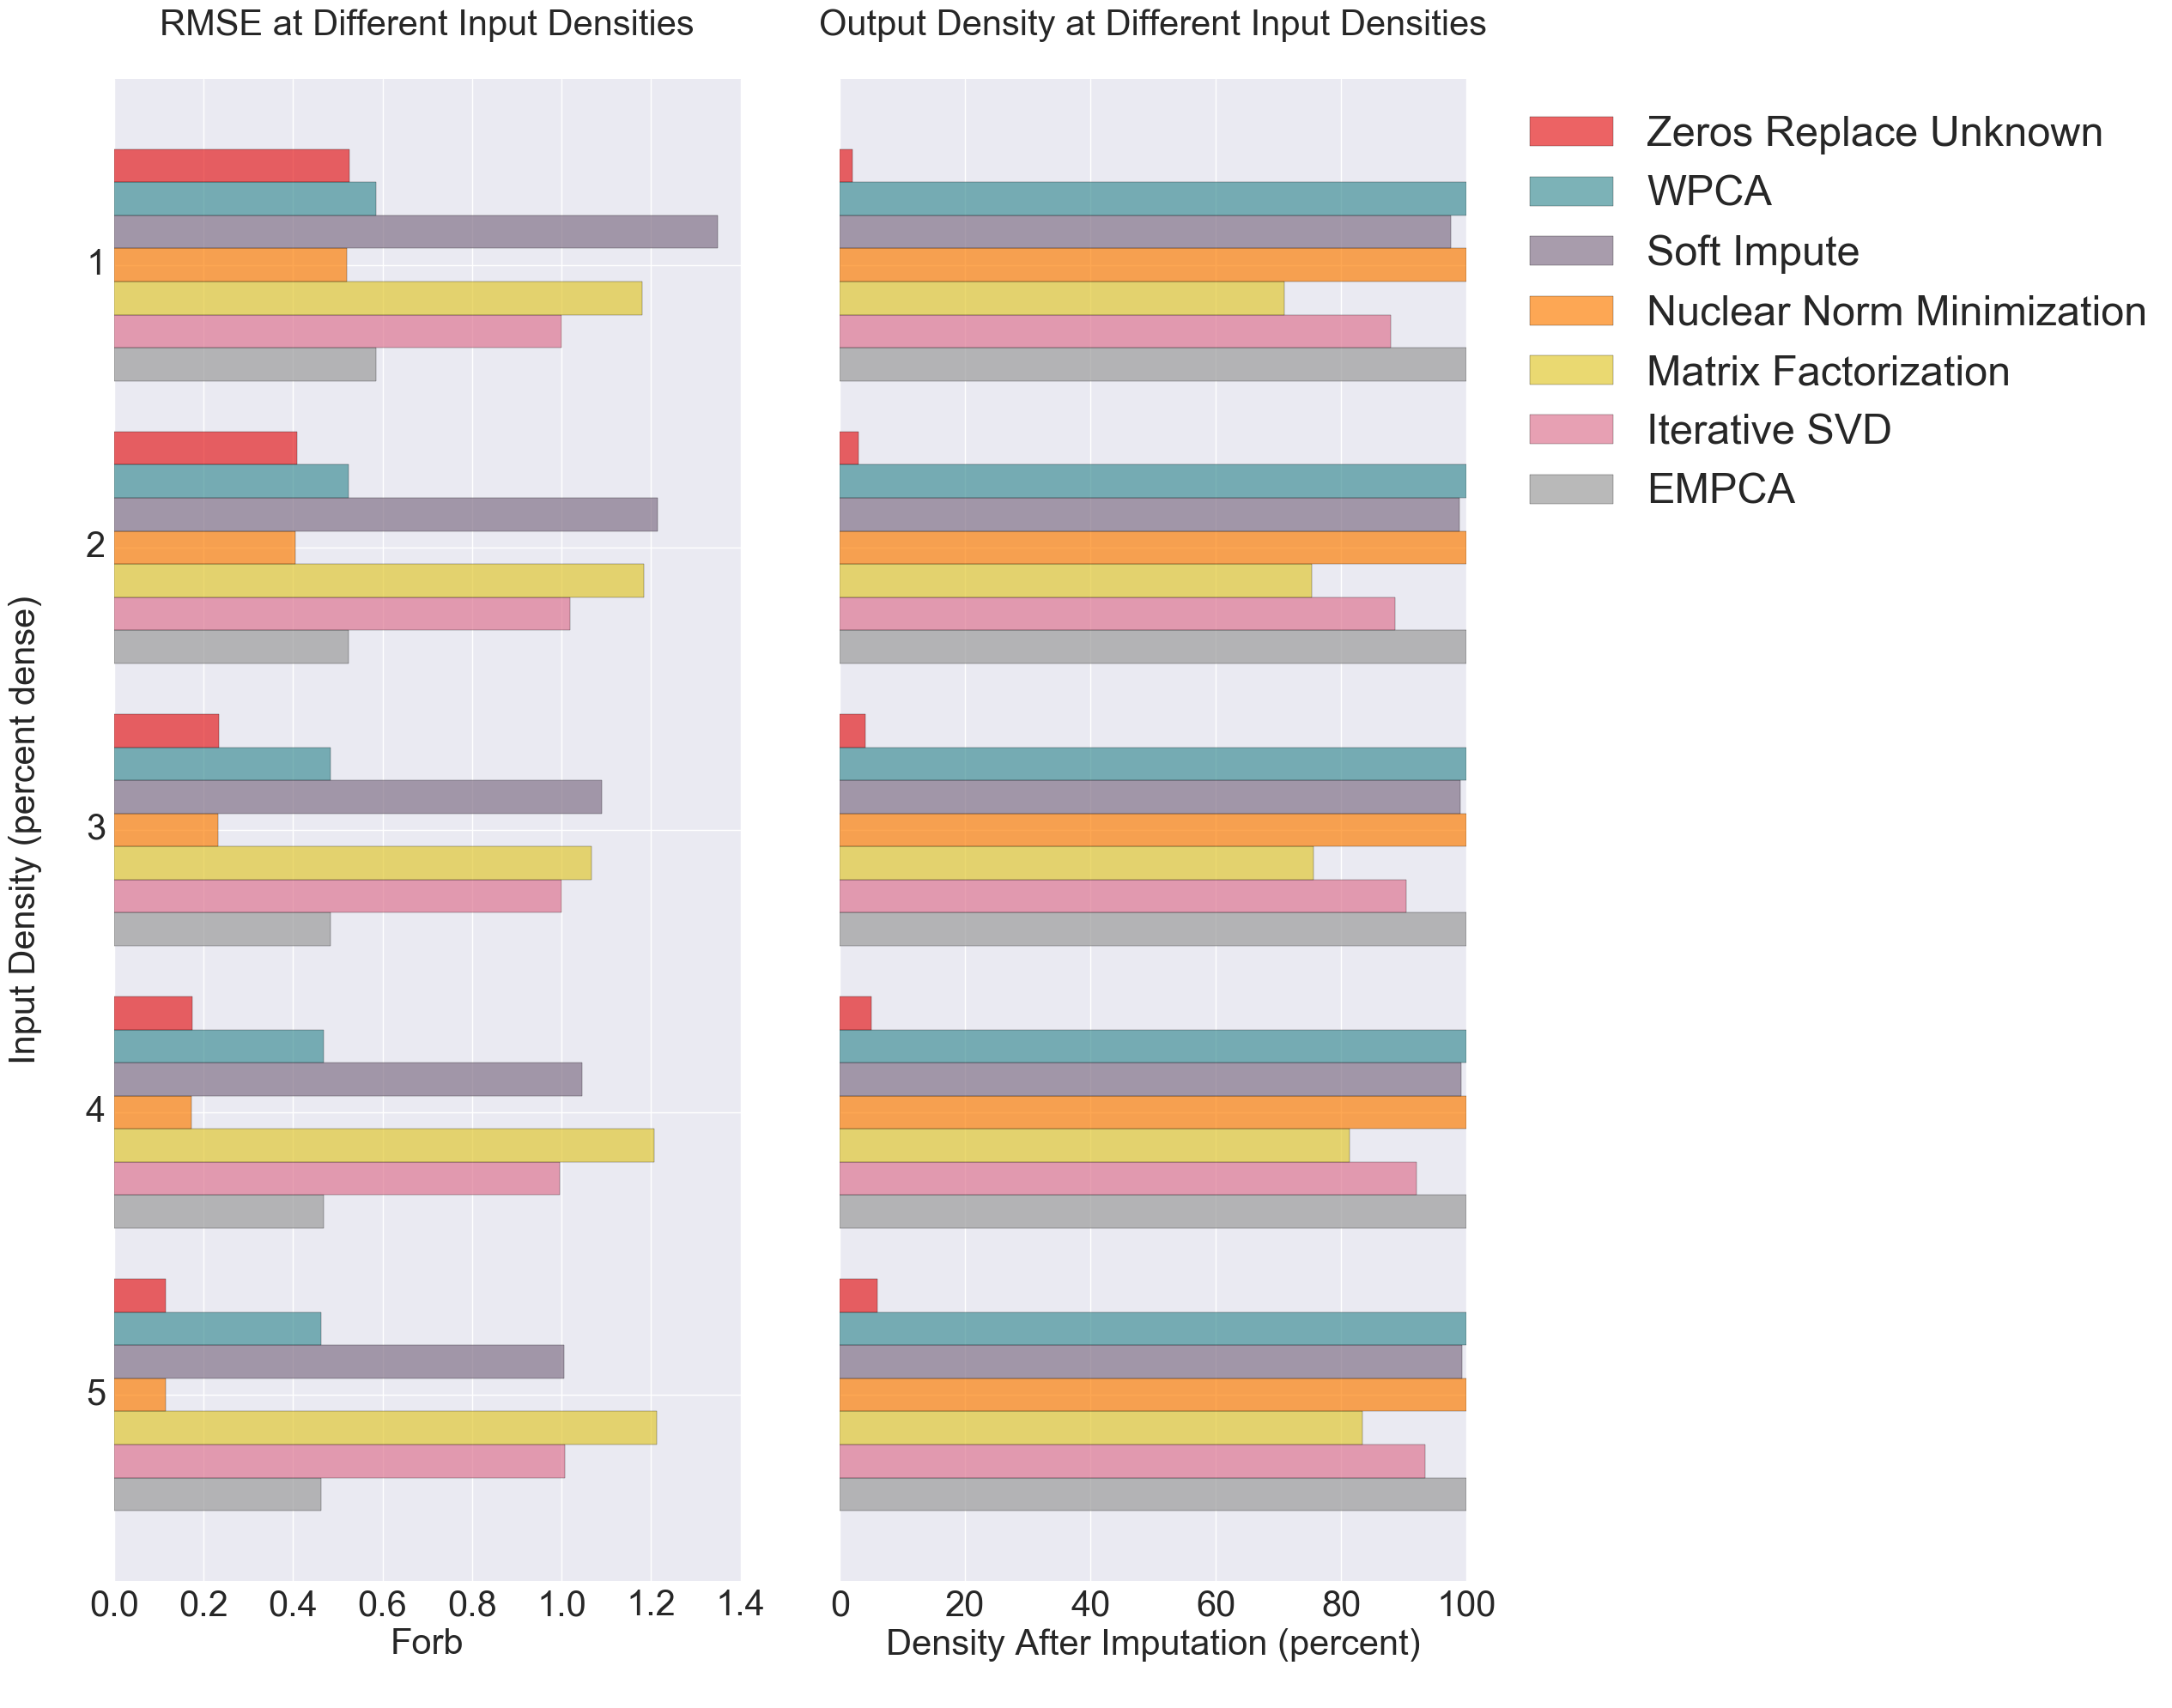

In [108]:
#save results as dataframe 
RMSEmapping = pd.DataFrame({'Density': list(map(int, density_in)),'EMPCA': RMSE_empca_scores,'Matrix Factorization': RMSE_smi_scores,'WPCA': RMSE_wpca_scores,'Soft Impute': RMSE_sfi_scores,'Iterative SVD': RMSE_siv_scores,'Nuclear Norm Minimization': RMSE_sni_scores,'Zeros Replace Unknown': RMSE_szi_scores})   
RMSEmapping.set_index(['Density'], inplace=True)
Out_density = pd.DataFrame({'density': list(map(int, density_in)),'EMPCA': Density_empca,'Matrix Factorization': Density_smi,'WPCA': Density_wpca,'Soft Impute': Density_sfi,'Iterative SVD': Density_siv,'Nuclear Norm Minimization': Density_sni,'Zeros Replace Unknown': Density_szi})   
Out_density.set_index(['density'], inplace=True)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 20),sharey=False)
RMSEmapping.plot(kind='barh',subplots=False,stacked=False,colormap="Set1_r",width=.82,alpha=.68,fontsize=30 ,ax=ax1)
Out_density.plot(kind="barh",subplots=False,stacked=False,sharey=True,colormap="Set1_r",width=.82,alpha=.68,fontsize=30,legend=False,ax=ax2)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':35}, bbox_to_anchor=(2.2, 1.0))
ax1.set_xlabel(('Forb'), fontsize=30)
ax1.set_ylabel('Input Density (percent dense)\n', fontsize=30)
ax2.set_xlabel('Density After Imputation (percent)\n', fontsize=30)
ax2.set_ylabel('Density After Imputation (percent)\n', fontsize=30)
ax1.set_title(('RMSE at Different Input Densities\n'), fontsize=30)
ax2.set_title(('Output Density at Different Input Densities\n'), fontsize=30)
fig.set_tight_layout(True)
#plt.savefig('/Users/cameronmartino/bin/DEICODE/out2/88soils_benchmark2.png',bbox_to_anchor=(2.2, 1.0), dpi=300, bbox_inches='tight')
fig.show()

# RMSE Between Each Matrix

 In general as values are removed all methods increase in the RMSE error to the original matrix. The method used to remove values is very important. Only low frequency OTUs in each sample are removed to simulate the under or small segment sampling used in 16S studies. Because of this the zero method of imputation has a low RMSE or high accuracy. Zeros minimize the probability of being wrong by guessing the smallest possible value of zero. Nuclear Norm Rank Minimization by Convex Optimized Decomposition had the same scores as the zeros. The only downside to this method is although it is exact it does not scale well with large datasets. The next lowest RMSE are Soft Impute, WPCA, EMPCA and Iterative SVD. These may be possible contenders due to their scaleability with large datasets. 

# Density after imputation

Although zero imputation is widely used and has a low RMSE at low densities it produces very sparse matrices preventing the use of many powerful statistical tools. Below you can see at each input density (x-axis) the output density for all imputations methods is ~100% dense with exception of the k-Nearest Neighbors method. While the zero imputation adds sparsity.

# Visualize pH trend in Completion

Soft impute seems like a good ratio between RMSE, speed and density. Let's see how the pH trend in these soil samples is maintained while also creating a fully dense matrix using Soft Impute.

http://web.stanford.edu/%7Ehastie/Papers/mazumder10a.pdf

In [134]:
#build dataframe and sort the pH niche 
observed_table=niche_sort(otu, mappingdf.pH)
otummapping = pd.DataFrame(otum, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_m = niche_sort(otummapping, mappingdf.pH)
observed_table_m= observed_table_m[observed_table.columns.tolist()]
new_otu_sni = pd.DataFrame(siv.T, columns=otu.columns.tolist(),index=otu.index.tolist())
observed_table_sni = niche_sort(new_otu_sni, mappingdf.pH)





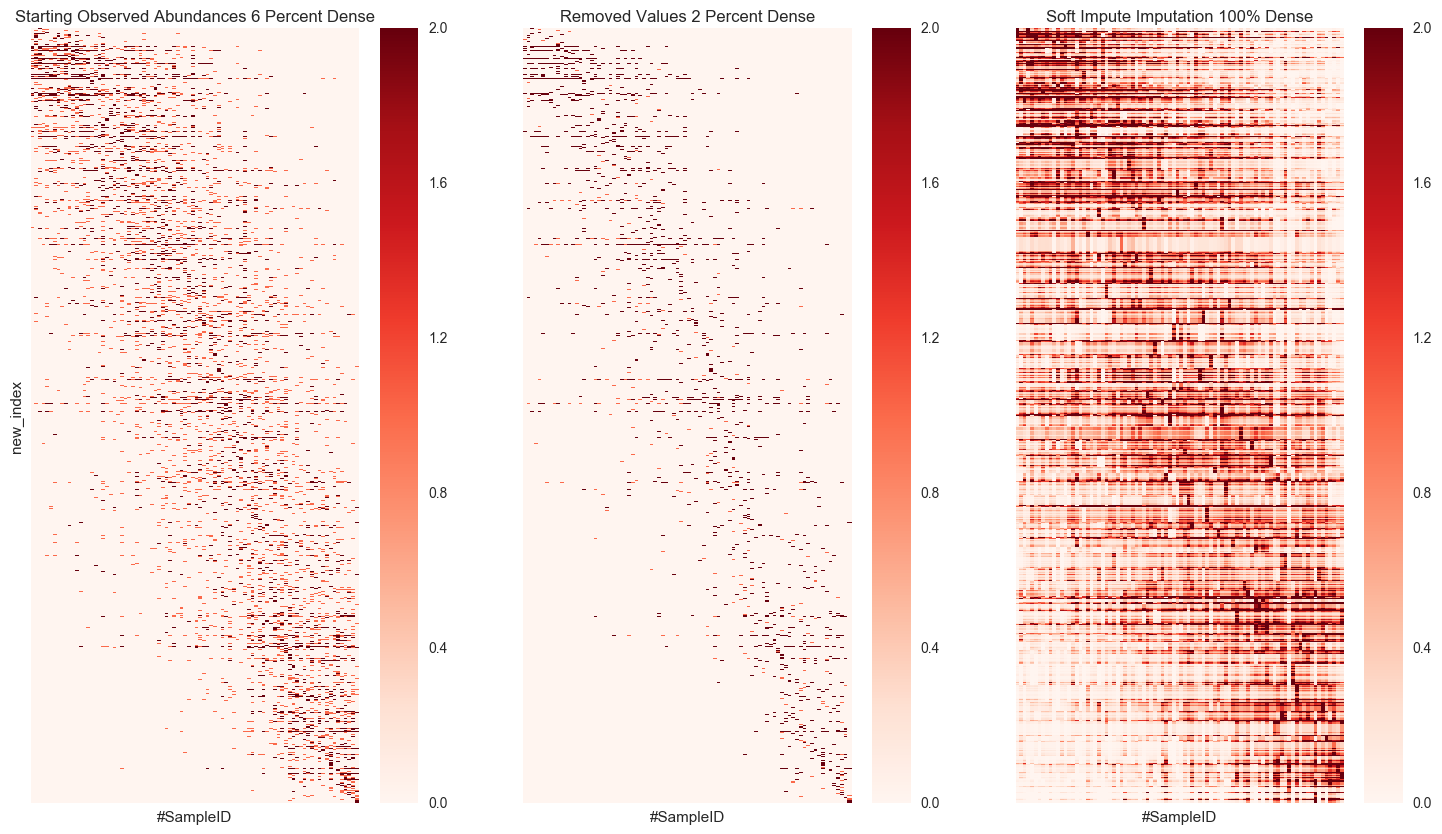

In [82]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 10))
sns.heatmap(observed_table.T, robust=False,vmin=0,vmax=2,cmap="Reds", ax=ax1)
sns.heatmap(observed_table_m.T, robust=False,vmin=0,vmax=2,cmap="Reds", ax=ax2)
sns.heatmap(observed_table_sni.T, robust=False,vmin=0,vmax=2,cmap="Reds", ax=ax3)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax1.set_title('Starting Observed Abundances %i Percent Dense'%(int(begin*100)))
ax2.set_title('Removed Values %i Percent Dense'%(int(d*100)))
ax3.set_title('Soft Impute Imputation 100% Dense')

# PCA (DEICODE example)

Having a fully dense matrix allows you to use many statical tools you can not use with zero imputation due to sparsity and outliers. You can use the imputed matrix for PCA.

(https://github.com/cjm007/DEICODE)

#### PCA on zero impute data density of  2%

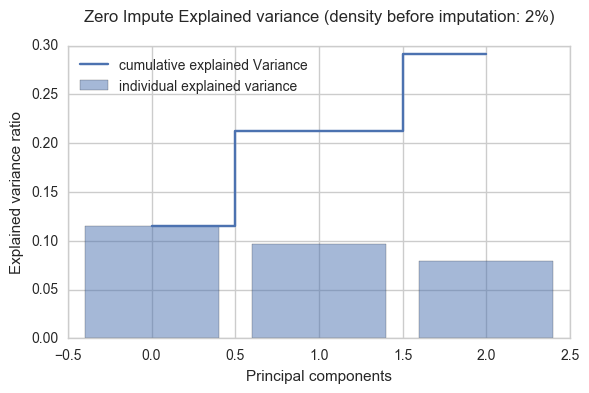

In [135]:
#check matching
observed_table_m, mapping = match(observed_table_m, mappingdf)
pca_model2=PCA(n_components=3)
X1=observed_table_m.as_matrix()
X_reduced1 = pca_model2.fit_transform(X1)
var_exp=pca_model2.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model2.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained Variance')
    plt.title(('Zero Impute Explained variance (density before imputation: 2%)\n'))
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.savefig('/Users/cameronmartino/bin/DEICODE/out2/88soils_zero_imput_var.png',bbox_to_anchor=(2.2, 1.0), dpi=300, bbox_inches='tight')
    plt.tight_layout()

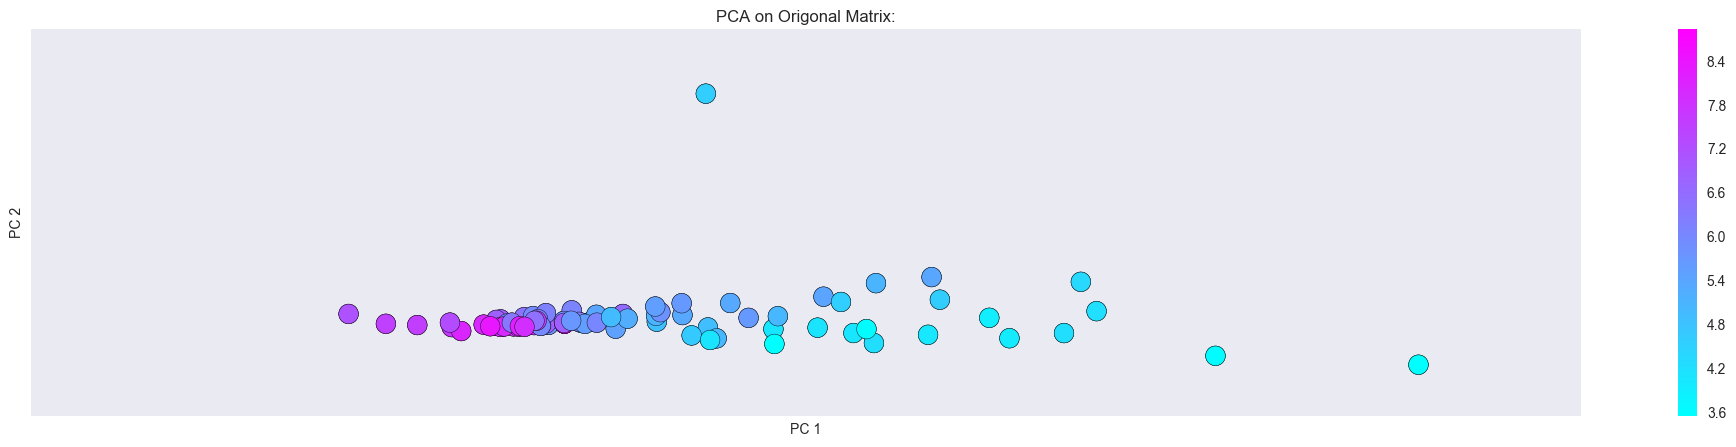

In [136]:
#plot pca
Y=mapping["pH"].tolist()
plt.figure(2, figsize=(25,5))
plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)
plt.show()

As you can see the zero impute data how low explained variance in the first three axis and a large outlier. 

#### PCA on Iterative SVD data, 100% dense

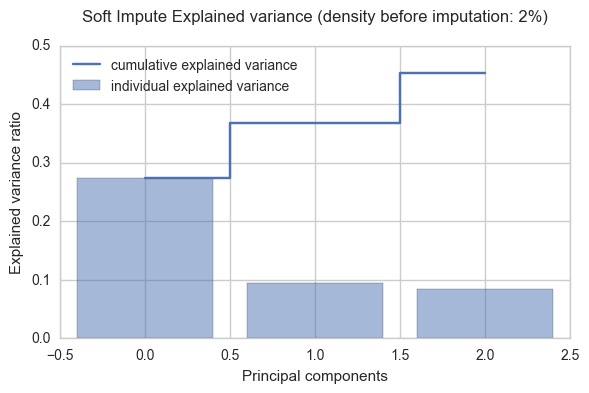

In [137]:
#check matching
observed_table_sni, mapping = match(observed_table_sni, mappingdf)
pca_model=PCA(n_components=3)
X2=observed_table_sni.as_matrix()
X_reduced2 = pca_model.fit_transform(X2)
var_exp=pca_model.explained_variance_ratio_
cum_var_exp = np.cumsum(pca_model.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6,4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.title(('Soft Impute Explained variance (density before imputation: 2%)\n'))
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
plt.savefig('/Users/cameronmartino/bin/DEICODE/out2/88soils_soft_imput_var.png',bbox_to_anchor=(2.2, 1.0), dpi=300, bbox_inches='tight')
plt.tight_layout()

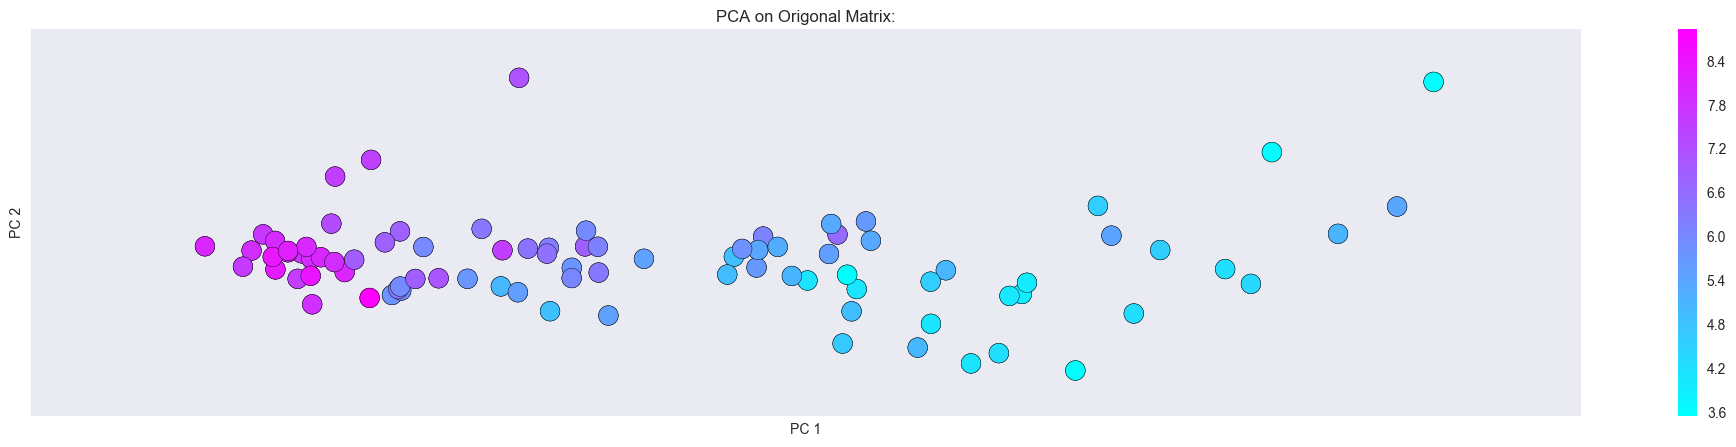

In [138]:
#plot pca
Y=mapping["pH"].tolist()
plt.figure(2, figsize=(25,5))
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
p=plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=Y,cmap=plt.cm.cool,s=200)
plt.title("PCA on Origonal Matrix:")
plt.xlabel("PC 1", fontsize=10)
plt.xticks([])
plt.yticks([])
plt.ylabel("PC 2", fontsize=10)
plt.colorbar(p)


plt.show()

In the complete data the outlier is no longer present and the explained variance is vastly increased.

This allows you to extract what OTUs cause the most variance on the axis that explains your data best.

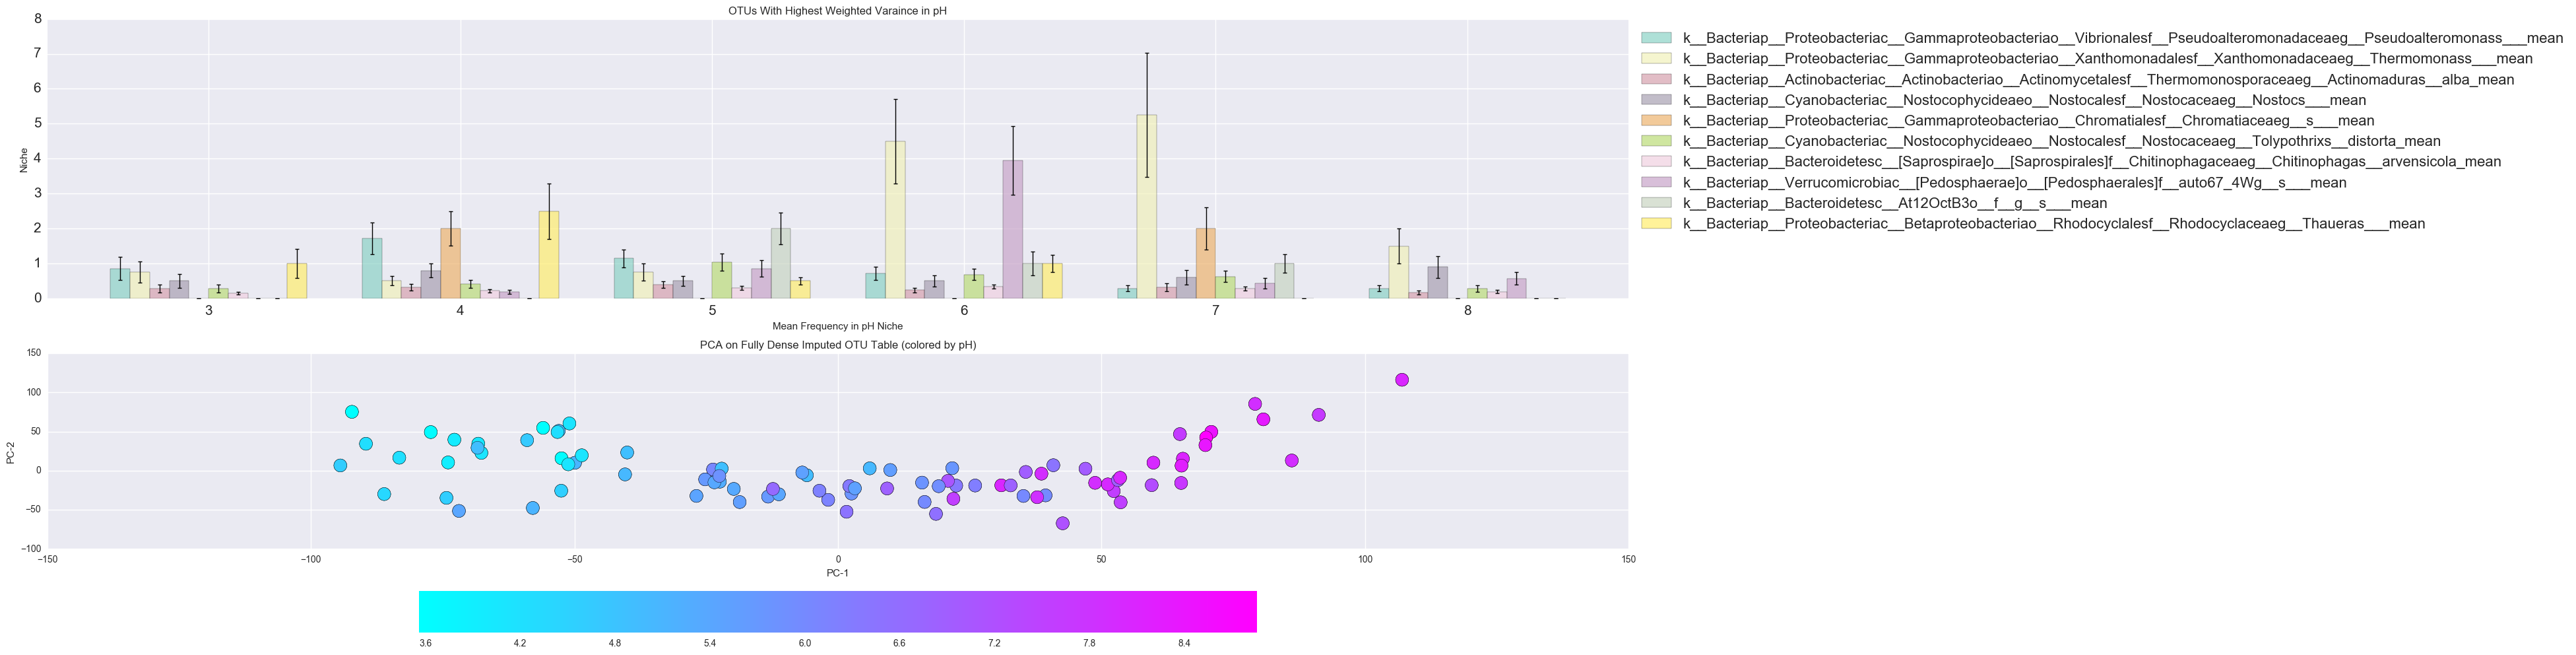

In [867]:
#cond
otu # orignal data
tax_index # list of taxa in order of otus (0-end)
bact_to_show=10 # number of bacteria to extract
niche_plot='pH' # any column from mapping
Pc_plot="PC-1" # can be PC-2
imputed_in=sfi.copy() # imputed data to use
cont=True # default true, false if not continous data

# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std = PCA_niche.niche_visual(otu,sfi,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf)
# Visualize the data
plt = PCA_niche.plot_niche(out_niche_linkeddf,observed_table_sfi,mappingdf,niche_plot,Pc_plot,index_mean,index_std,cont)
plt.show()